In [62]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.3}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [81]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games") as con:
    con.row_factory = dict_factory
    res = con.execute(
        """
        SELECT 
            g.result,
            m.eval,
            m.ply,
            m.material_white - m.material_black as balance
        FROM 
            games g INNER JOIN moves m 
            ON g.url = m.url
        WHERE
            g.result != 3
            AND m.eval is not NULL
        """
    )
    df = pd.DataFrame(res)
con.close()


In [82]:
random_state = 42

features = ["eval", "ply", "balance"]
X = df.loc[:, features]
y = df.result

classifier = LogisticRegression(random_state=random_state, n_jobs=-1)
scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

<AxesSubplot: xlabel='eval', ylabel='result'>

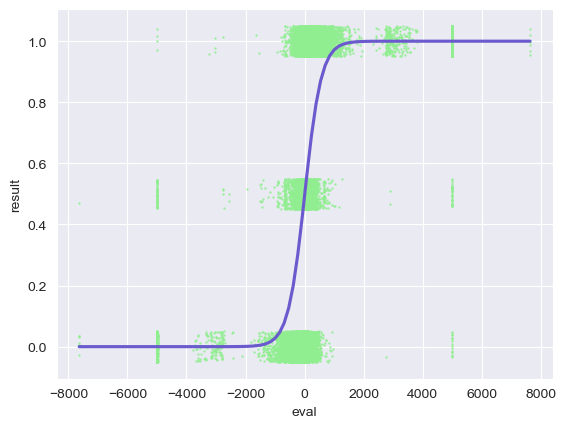

In [94]:
sns.regplot(
    data=(df + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [92]:
model.fit(X_train, y_train)
print(f"Accuracy: {model.score(X_test, y_test)}")


Accuracy: 0.6058219659682182


In [91]:
coefs = model.named_steps["logisticregression"].coef_/model.named_steps["standardscaler"].scale_
print(f"Coefficients: \n {coefs}")

Coefficients: 
 [[-0.00109 -0.00884 -0.0478]
 [-0.000241 0.0177 0.0266]
 [0.00134 -0.0089 0.0212]]


<AxesSubplot: xlabel='ply', ylabel='eval'>

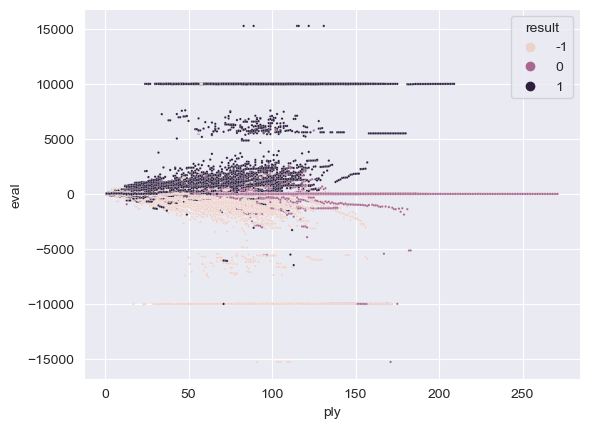

In [86]:
sns.scatterplot(
    df,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    # palette="icefire",
)


In [87]:
plys = np.arange(0, 150, 1)
evals = np.arange(-2000, 2000, 20)
wins_list = []
coords_list = []
for ply in plys:
    for eval in evals:
        wins_list.append(model.predict_proba([[eval, ply, 1]])[0])
        coords_list.append([eval, ply])
coords = np.array(coords_list)
wins = np.array(wins_list)


c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: 

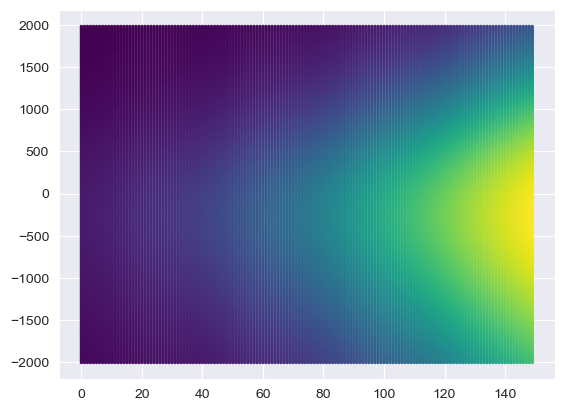

In [88]:
plt.scatter(x=coords[:, 1], y=coords[:, 0], c=wins[:, 1], cmap="viridis", s=2)


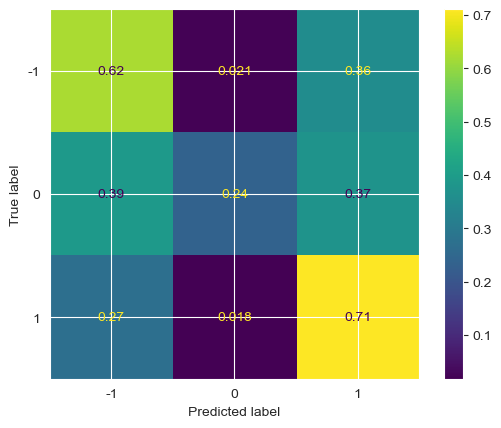

In [90]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize="true")
